<a href="https://colab.research.google.com/github/Giridhar57/ML_Repo/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Classification with Transfer Learning**

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.pyplot as plt
 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/vehicle'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [ ]:
train_data.class_to_idx

{'bike': 0, 'bus': 1, 'car': 2, 'truck': 3}

In [ ]:
model = models.resnet18(pretrained=True)
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 4)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = fc

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 400)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(400, 4)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
epochs = 15
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/15.. Train loss: 2.315.. Test loss: 2.267.. Test accuracy: 0.250
Epoch 1/15.. Train loss: 1.832.. Test loss: 0.998.. Test accuracy: 0.738
Epoch 1/15.. Train loss: 1.371.. Test loss: 0.995.. Test accuracy: 0.675
Epoch 1/15.. Train loss: 1.208.. Test loss: 0.905.. Test accuracy: 0.750
Epoch 1/15.. Train loss: 1.184.. Test loss: 0.779.. Test accuracy: 0.700
Epoch 2/15.. Train loss: 0.809.. Test loss: 0.811.. Test accuracy: 0.662
Epoch 2/15.. Train loss: 1.014.. Test loss: 0.731.. Test accuracy: 0.675
Epoch 2/15.. Train loss: 0.967.. Test loss: 0.580.. Test accuracy: 0.812
Epoch 2/15.. Train loss: 0.888.. Test loss: 0.585.. Test accuracy: 0.850
Epoch 2/15.. Train loss: 0.963.. Test loss: 0.451.. Test accuracy: 0.875
Epoch 3/15.. Train loss: 0.851.. Test loss: 0.949.. Test accuracy: 0.500
Epoch 3/15.. Train loss: 1.068.. Test loss: 0.464.. Test accuracy: 0.875
Epoch 3/15.. Train loss: 1.274.. Test loss: 0.690.. Test accuracy: 0.750
Epoch 3/15.. Train loss: 0.922.. Test loss: 0.636..

In [ ]:
torch.save(model.state_dict(), 'res18_10.pth')

In [ ]:
def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(512, 400)),
                      ('relu', nn.ReLU()),
                      ('fc2', nn.Linear(400, 4)),
                      ('output', nn.LogSoftmax(dim=1))
                      ]))

    model.load_state_dict(ckpt, strict=False)

    return model

In [ ]:
SAVE_PATH = 'res18_10.pth'

In [ ]:
model = load_ckpt(SAVE_PATH)

In [ ]:
import PIL
def process_image(image):
    im = PIL.Image.open(image)
    return test_transforms(im)

In [ ]:
def predict(image_path, model):
    model.eval()
    img_pros = process_image(image_path)
    img_pros = img_pros.view(1,3,224,224)
    with torch.no_grad():
        output = model(img_pros)
    return output

In [ ]:
def img_pred(impath):
  img_path = impath
  cls_score = int(torch.argmax(torch.exp(predict(img_path, model))))
  print("Predicted Output:",end=' ')
  if cls_score == 0:
      print('Bike')
  elif cls_score==1:
      print('Bus')
  elif cls_score==2:
      print('Car')
  else:
      print('Truck')
  print("Prediction Status :",torch.exp(predict(img_path, model)))

### ***Testing Image classification Status with some example images***



Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/1.png
Predicted Output: Bike
Prediction Status : tensor([[0.9445, 0.0423, 0.0037, 0.0096]])


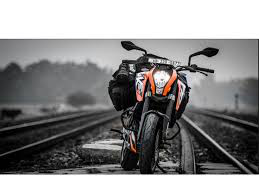

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/18.png
Predicted Output: Truck
Prediction Status : tensor([[0.0013, 0.0085, 0.0019, 0.9883]])


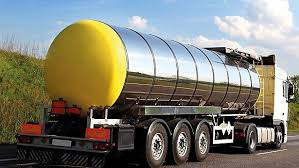

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/14.png
Predicted Output: Bus
Prediction Status : tensor([[0.0511, 0.7889, 0.0072, 0.1528]])


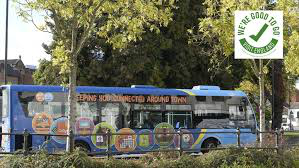

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/10.png
Predicted Output: Car
Prediction Status : tensor([[7.2480e-04, 1.0879e-03, 9.9782e-01, 3.7046e-04]])


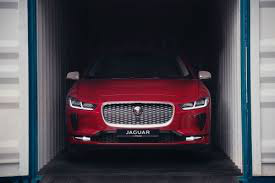

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/15.png
Predicted Output: Bus
Prediction Status : tensor([[0.0684, 0.8969, 0.0076, 0.0271]])


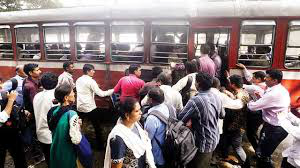

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/16.png
Predicted Output: Truck
Prediction Status : tensor([[1.1651e-04, 5.3093e-03, 2.3527e-05, 9.9455e-01]])


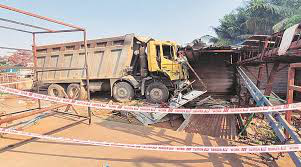

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/3.png
Predicted Output: Bike
Prediction Status : tensor([[9.9974e-01, 1.3179e-04, 3.6508e-05, 9.5975e-05]])


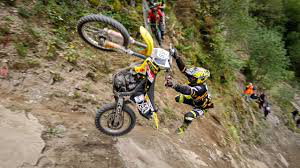

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/8.png
Predicted Output: Car
Prediction Status : tensor([[5.9777e-03, 1.2631e-02, 9.8093e-01, 4.6393e-04]])


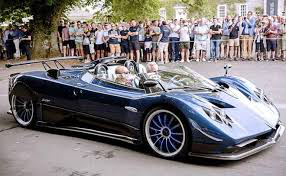

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/12.png
Predicted Output: Bus
Prediction Status : tensor([[0.0191, 0.5861, 0.0015, 0.3934]])


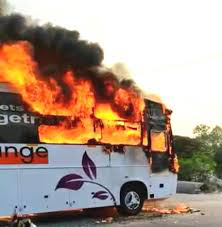

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/4.png
Predicted Output: Bike
Prediction Status : tensor([[9.8744e-01, 5.0046e-03, 9.3300e-04, 6.6231e-03]])


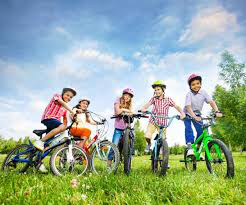

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)

Enter image path:/content/drive/MyDrive/Colab Notebooks/vehicle/classification/20.png
Predicted Output: Truck
Prediction Status : tensor([[3.8021e-04, 1.1950e-01, 1.2284e-04, 8.8000e-01]])


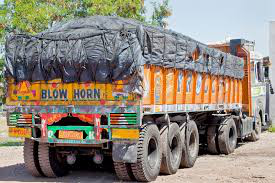

In [ ]:
impath=input("Enter image path:")
img_pred(impath)
PIL.Image.open(impath)